In [3]:
!pip install remotezip --quiet

In [30]:
import tqdm
import random
import pathlib
import itertools
import collections
import os
import cv2
import einops
import numpy as np
# !pip install remotezip
import remotezip as rz
import seaborn as sns
import tensorflow as tf
import keras
from keras import layers


# DATA LOADING


In [5]:
#modules to display animation using imageio
import imageio
from IPython import display
from urllib import request
!pip install tensorflow_docs
from tensorflow_docs.vis import embed

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.7/182.7 kB 13.6 MB/s eta 0:00:00


In [6]:
URL="https://storage.googleapis.com/thumos14_files/UCF101_videos.zip"

In [7]:
def list_files_via_zip_with(url):
  files=[]
  with rz.RemoteZip(url) as zip:
    for zip_info in zip.infolist():
      files.append(zip_info.filename)
  return files


In [8]:
files=list_files_via_zip_with(URL)

In [9]:
files=[file for file in files if file.endswith('.avi')]# store file only if it ends with .avi

In [10]:
files[:10]

['UCF101/v_ApplyEyeMakeup_g01_c01.avi',
 'UCF101/v_ApplyEyeMakeup_g01_c02.avi',
 'UCF101/v_ApplyEyeMakeup_g01_c03.avi',
 'UCF101/v_ApplyEyeMakeup_g01_c04.avi',
 'UCF101/v_ApplyEyeMakeup_g01_c05.avi',
 'UCF101/v_ApplyEyeMakeup_g01_c06.avi',
 'UCF101/v_ApplyEyeMakeup_g02_c01.avi',
 'UCF101/v_ApplyEyeMakeup_g02_c02.avi',
 'UCF101/v_ApplyEyeMakeup_g02_c03.avi',
 'UCF101/v_ApplyEyeMakeup_g02_c04.avi']

In [11]:
def get_class (fname):
  return fname.split('_')[-3]

In [12]:
get_class('UCF101/v_ApplyEyeMakeup_g01_c01.av')

'ApplyEyeMakeup'

In [14]:
def get_files_per_class(files):
  class_with_files=collections.defaultdict(list)
  for file in files:
    class_name=get_class(file)
    class_with_files[class_name].append(file)
  return class_with_files

In [15]:
NUM_CLASSES=10
FILES_PER_CLASS=50

In [16]:
files_for_class=get_files_per_class(files)
classes=list(files_for_class.keys())

In [17]:
len(classes)
# len(files_for_class[classes[0]])

101

In [ ]:
#145 vids,101 categories

In [18]:
def select_subset_of_classes(files_for_class,classes,files_per_class):
  files_subset=dict()
  for class_name in classes:
    class_files=files_for_class[class_name]
    files_subset[class_name]=class_files[:files_per_class]
  return files_subset

In [19]:
files_subset=select_subset_of_classes(files_for_class,classes[:NUM_CLASSES],FILES_PER_CLASS)

In [20]:
len(files_subset['ApplyEyeMakeup'])

50

In [32]:
def download_videos(url,to_dir,file_names):
  with rz.RemoteZip(url) as zip:
    for fn in tqdm.tqdm(file_names):
      class_name=get_class(fn)
      zip.extract(fn,str(to_dir/class_name))
      unzipped_file=to_dir/class_name/fn

      fn = pathlib.Path(fn).parts[-1]
      output_file = to_dir / class_name / fn
      unzipped_file.rename(output_file)

In [33]:
files_for_class[classes[2]][:5]

['UCF101/v_Archery_g01_c01.avi',
 'UCF101/v_Archery_g01_c02.avi',
 'UCF101/v_Archery_g01_c03.avi',
 'UCF101/v_Archery_g01_c04.avi',
 'UCF101/v_Archery_g01_c05.avi']

In [34]:
def split_class_lists(files_for_class,count):
  split_files=[]
  remainder={}
  for cls in files_for_class:
    split_files.extend(files_for_class[cls][:count])
    remainder[cls]=files_for_class[cls][count:]
  return split_files,remainder

In [35]:
def download_dataset(zip_url,num_classes,splits,download_dir):

  files=list_files_via_zip_with(zip_url)
  for f in files:
#removing // or etc
    path=os.path.normpath(f)
# splitting name of file
    tokens=path.split(os.sep)
    if len(tokens)<=2:
      files.remove(f) # remove file  if no filename
  #getting files with classes :limited acc to arguements
  files_for_class=get_files_per_class(files)
  #get limited classes
  classes=list(files_for_class.keys())[:num_classes]

  for cls in classes:
    random.shuffle(files_for_class[cls])

  #only is the number of classes u want in dictionary
  files_for_class={cls : files_for_class[cls] for cls in classes}

  dirs={}

  for split_name,split_count in splits.items():
    print(split_name," :")

    split_dir=download_dir/split_name
    split_files,files_for_class =split_class_lists(files_for_class,split_count)

    download_videos(zip_url,split_dir,split_files)
    dirs[split_name]=split_dir
  return dirs


In [36]:
download_dir=pathlib.Path('./content/UCF101_subset/')
subset_paths=download_dataset(URL,NUM_CLASSES,{'train':30,'val':10,'test':10},download_dir)

train  :


100%|██████████| 300/300 [05:22<00:00,  1.07s/it]


val  :


100%|██████████| 100/100 [01:34<00:00,  1.06it/s]


test  :


100%|██████████| 100/100 [01:37<00:00,  1.03it/s]


In [37]:
video_count_train = len(list(download_dir.glob('train/*/*.avi')))
video_count_val = len(list(download_dir.glob('val/*/*.avi')))
video_count_test = len(list(download_dir.glob('test/*/*.avi')))
video_total = video_count_train + video_count_val + video_count_test
print(f"Total videos: {video_total}")

Total videos: 500


In [39]:
!find ./content/UCF101_subset


./content/UCF101_subset
./content/UCF101_subset/train
./content/UCF101_subset/train/Archery
./content/UCF101_subset/train/Archery/v_Archery_g06_c05.avi
./content/UCF101_subset/train/Archery/v_Archery_g20_c05.avi
./content/UCF101_subset/train/Archery/v_Archery_g11_c06.avi
./content/UCF101_subset/train/Archery/v_Archery_g16_c01.avi
./content/UCF101_subset/train/Archery/v_Archery_g21_c04.avi
./content/UCF101_subset/train/Archery/UCF101
./content/UCF101_subset/train/Archery/v_Archery_g06_c01.avi
./content/UCF101_subset/train/Archery/v_Archery_g11_c04.avi
./content/UCF101_subset/train/Archery/v_Archery_g03_c04.avi
./content/UCF101_subset/train/Archery/v_Archery_g20_c07.avi
./content/UCF101_subset/train/Archery/v_Archery_g02_c03.avi
./content/UCF101_subset/train/Archery/v_Archery_g15_c02.avi
./content/UCF101_subset/train/Archery/v_Archery_g08_c01.avi
./content/UCF101_subset/train/Archery/v_Archery_g12_c01.avi
./content/UCF101_subset/train/Archery/v_Archery_g02_c05.avi
./content/UCF101_subset

# PreProcessing Data

In [55]:
def format_frames(frame,output_size):
  #setting frames
  #padding and resizing
  #output size
  frame=tf.image.convert_image_dtype(frame,tf.float32)
  frame=tf.image.resize_with_pad(frame,*output_size)
  return frame

main class

In [56]:
def frames_from_video_file(video_path, n_frames, output_size = (224,224), frame_step = 15):
  """
    Creates frames from each video file present for each category.

    Args:
      video_path: File path to the video.
      n_frames: Number of frames to be created per video file.
      output_size: Pixel size of the output frame image.

    Return:
      An NumPy array of frames in the shape of (n_frames, height, width, channels).
  """
  # Read each video frame by frame
  result = []
  src = cv2.VideoCapture(str(video_path))

  video_length = src.get(cv2.CAP_PROP_FRAME_COUNT)

  need_length = 1 + (n_frames - 1) * frame_step

  if need_length > video_length:
    start = 0
  else:
    max_start = video_length - need_length
    start = random.randint(0, max_start + 1)

  src.set(cv2.CAP_PROP_POS_FRAMES, start)
  # ret is a boolean indicating whether read was successful, frame is the image itself
  ret, frame = src.read()
  result.append(format_frames(frame, output_size))

  for _ in range(n_frames - 1):
    for _ in range(frame_step):
      ret, frame = src.read()
    if ret:
      frame = format_frames(frame, output_size)
      result.append(frame)
    else:
      result.append(np.zeros_like(result[0]))
  src.release()
  result = np.array(result)[..., [2, 1, 0]]

  return result

In [57]:
!curl -O https://upload.wikimedia.org/wikipedia/commons/8/86/End_of_a_jam.ogv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 55.0M  100 55.0M    0     0  28.1M      0  0:00:01  0:00:01 --:--:-- 28.1M


In [58]:
video_path = "End_of_a_jam.ogv"

In [59]:
sample_video =frames_from_video_file(video_path,n_frames=10)


In [61]:
sample_video.shape

(10, 224, 224, 3)

In [62]:
def to_gif(images):
  converted_images = np.clip(images * 255, 0, 255).astype(np.uint8)
  imageio.mimsave('./animation.gif', converted_images, fps=10)
  return embed.embed_file('./animation.gif')


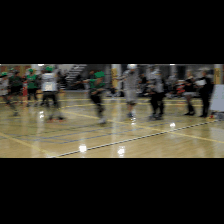

In [64]:
to_gif(sample_video)

FRame Generator

In [65]:
class FrameGenerator:
  def __init__(self,path,n_frames,training=False):
    self.path = path
    self.n_frames = n_frames
    self.training = training
    self.class_names = sorted(set(p.name for p in self.path.iterdir() if p.is_dir()))
    self.class_ids_for_name = dict((name, idx) for idx, name in enumerate(self.class_names))

  def get_files_and_class_names(self):
    video_paths=list(self.path.glob('*/*.avi'))
    classes=[p.parent.name for p in video_paths]
    return video_paths,classes


  def __call__(self):
    video_paths, classes = self.get_files_and_class_names()

    pairs = list(zip(video_paths, classes))

    if self.training:
      random.shuffle(pairs)

    for path, name in pairs:
      video_frames = frames_from_video_file(path, self.n_frames)
      label = self.class_ids_for_name[name] # Encode labels
      yield video_frames, label

In [73]:
from pathlib import Path

fg = FrameGenerator(Path('/content/content/UCF101_subset/train'), n_frames=10, training=True)


In [75]:
frames,label=next(fg())

In [76]:
print(f"shape:{frames.shape}")
print(f"Label:{label}")

shape:(10, 224, 224, 3)
Label:3


In [123]:
# Create the training set
output_signature = (
    tf.TensorSpec(shape=(10, 224, 224, 3), dtype=tf.float32),
    tf.TensorSpec(shape=(),                  dtype=tf.int32)
)
fg_train = FrameGenerator(Path('/content/content/UCF101_subset/train'), n_frames=10, training=True)

train_ds = tf.data.Dataset.from_generator(fg_train, output_signature=output_signature)


In [124]:
for frames,labels in train_ds.take(10):
  print(labels)

tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(7, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(8, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)


In [127]:

output_signature = (
    tf.TensorSpec(shape=(10, 224, 224, 3), dtype=tf.float32),
    tf.TensorSpec(shape=(),                  dtype=tf.int32)
)

fg_val = FrameGenerator(Path('/content/content/UCF101_subset/val'), n_frames=10, training=False)

val_ds = tf.data.Dataset.from_generator(fg_val, output_signature=output_signature)


In [128]:
# Print the shapes of the data
train_frames, train_labels = next(iter(train_ds))
print(f'Shape of training set of frames: {train_frames.shape}')
print(f'Shape of training labels: {train_labels.shape}')

val_frames, val_labels = next(iter(val_ds))
print(f'Shape of validation set of frames: {val_frames.shape}')
print(f'Shape of validation labels: {val_labels.shape}')

Shape of training set of frames: (10, 224, 224, 3)
Shape of training labels: ()
Shape of validation set of frames: (10, 224, 224, 3)
Shape of validation labels: ()


creating batch of the dataset

In [129]:
train_ds = train_ds.batch(2)
val_ds = val_ds.batch(2)

train_frames, train_labels = next(iter(train_ds))
print(f'Shape of training set of frames: {train_frames.shape}')
print(f'Shape of training labels: {train_labels.shape}')

val_frames, val_labels = next(iter(val_ds))
print(f'Shape of validation set of frames: {val_frames.shape}')
print(f'Shape of validation labels: {val_labels.shape}')

Shape of training set of frames: (2, 10, 224, 224, 3)
Shape of training labels: (2,)
Shape of validation set of frames: (2, 10, 224, 224, 3)
Shape of validation labels: (2,)


In [130]:

#Trying transfer learning
import tensorflow as tf

In [132]:
# 2) Pull one batch and inspect its contents:
for ds, name in [(train_ds, "TRAIN"), (val_ds, "VAL")]:
    batch_v, batch_l = next(iter(ds))
    print(f"\n{name} batch:")
    print("  frames shape:", batch_v.shape, " dtype:", batch_v.dtype)
    print("  labels shape:", batch_l.shape, " dtype:", batch_l.dtype)



TRAIN batch:
  frames shape: (2, 10, 224, 224, 3)  dtype: <dtype: 'float32'>
  labels shape: (2,)  dtype: <dtype: 'int32'>

VAL batch:
  frames shape: (2, 10, 224, 224, 3)  dtype: <dtype: 'float32'>
  labels shape: (2,)  dtype: <dtype: 'int32'>


# Transfer Learning

In [133]:
net = tf.keras.applications.EfficientNetB0(include_top = False)
net.trainable = False

model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(scale=255),
    tf.keras.layers.TimeDistributed(net),
    tf.keras.layers.Dense(10),
    tf.keras.layers.GlobalAveragePooling3D()
])

model.compile(optimizer = 'adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
              metrics=['accuracy'])

model.fit(train_ds,
          epochs = 10,
          validation_data = val_ds,
          callbacks = tf.keras.callbacks.EarlyStopping(patience = 2, monitor = 'val_loss'))


Epoch 1/10
    150/Unknown 215s 273ms/step - accuracy: 0.4856 - loss: 1.6288

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


150/150 ━━━━━━━━━━━━━━━━━━━━ 266s 617ms/step - accuracy: 0.4871 - loss: 1.6254 - val_accuracy: 0.9200 - val_loss: 0.4726
Epoch 2/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 56s 376ms/step - accuracy: 0.9656 - loss: 0.3429 - val_accuracy: 0.9800 - val_loss: 0.2588
Epoch 3/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 54s 362ms/step - accuracy: 0.9898 - loss: 0.1598 - val_accuracy: 0.9800 - val_loss: 0.1955
Epoch 4/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 82s 549ms/step - accuracy: 0.9922 - loss: 0.1037 - val_accuracy: 0.9700 - val_loss: 0.1596
Epoch 5/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 53s 354ms/step - accuracy: 0.9949 - loss: 0.0696 - val_accuracy: 0.9500 - val_loss: 0.1491
Epoch 6/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 82s 352ms/step - accuracy: 1.0000 - loss: 0.0470 - val_accuracy: 0.9700 - val_loss: 0.1259
Epoch 7/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 142s 756ms/step - accuracy: 1.0000 - loss: 0.0400 - val_accuracy: 0.9600 - val_loss: 0.1212
Epoch 8/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 53s 356ms/step - accuracy: 1.0000 - loss: 0.0310 - v

Testing on a dataset

In [138]:
import tensorflow as tf
import numpy as np
from pathlib import Path

# Path to  single test video
test_video_path = Path("/content/content/UCF101_subset/test/ApplyLipstick/v_ApplyLipstick_g01_c02.avi")

# 1. Extract frames from video
frames = frames_from_video_file(test_video_path, n_frames=10)  # shape: (10, 224, 224, 3)

# 2. Add a batch dimension: (1, 10, 224, 224, 3)
frames = tf.expand_dims(frames, axis=0)

# 3. Pass it to your model
pred = model(frames)  # shape: (1, num_classes)

# 4. Get predicted label
pred_label = tf.argmax(pred, axis=-1).numpy()[0]
print("Predicted class ID:", pred_label)

Predicted class ID: 1


In [ ]:
import tensorflow as tf
import numpy as np
from pathlib import Path

# Path to  single test video
test_video_path = Path("/content/content/UCF101_subset/test/Archery/v_Archery_g08_c03.avi")

# 1. Extract frames from video
frames = frames_from_video_file(test_video_path, n_frames=10)  # shape: (10, 224, 224, 3)

# 2. Add a batch dimension: (1, 10, 224, 224, 3)
frames = tf.expand_dims(frames, axis=0)

# 3. Pass it to your model
pred = model(frames)  # shape: (1, num_classes)

# 4. Get predicted label
pred_label = tf.argmax(pred, axis=-1).numpy()[0]
print("Predicted class ID:", pred_label)

In [139]:
#0:apply makeup
#1:apply lipstick
#2: archery

#ngl pretty good.


# Model Creation